In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [3]:
labels = os.listdir(r"D:\VIT\train")

In [4]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

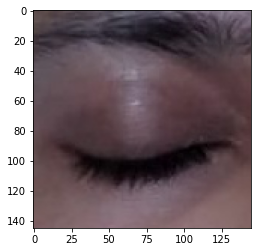

In [6]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"D:\VIT\train\Closed\_0.jpg"))

## Image array

In [7]:
a = plt.imread(r"D:\VIT\train\yawn\10.jpg")

## Image shape

In [8]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


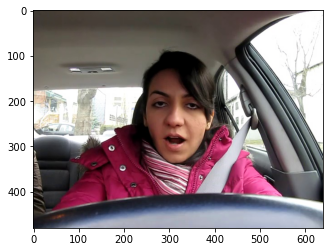

In [9]:
plt.imshow(plt.imread(r"D:\VIT\train\yawn\10.jpg"))

## Take only face(For yawn and not_yawn)

In [11]:
def face_for_yawn(direc=r"D:\VIT\train", face_cas_path=r"D:\VIT\xml\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [15]:
def get_data(dir_path=r"D:\VIT\train", face_cas=r"D:\VIT\xml\haarcascade_frontalface_default.xml", eye_cas=r"D:\VIT\haar-cascade-files-master\haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [16]:
data_train = get_data()

2
3


## Extend data and Convert array

In [17]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [18]:
new_data = append_data()

0
1
2
3


<ipython-input-17-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


## Separate label and features

In [19]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [20]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [21]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [22]:
y = np.array(y)

## Train Test split

In [23]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [24]:
len(X_test)

578

## Import some dependencies

In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [26]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [27]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [28]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 135s 3s/step - loss: 1.1651 - accuracy: 0.4469 - val_loss: 0.6812 - val_accuracy: 0.7699
Epoch 2/50
43/43 [==============================] - 128s 3s/step - loss: 0.5515 - accuracy: 0.7788 - val_loss: 0.4720 - val_accuracy: 0.7751
Epoch 3/50
43/43 [==============================] - 127s 3s/step - loss: 0.3865 - accuracy: 0.8248 - val_loss: 0.2866 - val_accuracy: 0.8858
Epoch 4/50
43/43 [==============================] - 128s 3s/step - loss: 0.3316 - accuracy: 0.8560 - val_loss: 0.2727 - val_accuracy: 0.8858
Epoch 5/50
43/43 [==============================] - 127s 3s/step - loss: 0.3106 - accuracy: 0.8708 - val_loss: 0.2515 - val_accuracy: 0.9048
Epoch 6/50
43/43 [==============================] - 128s 3s/step - loss: 0.2731 - accuracy: 0.8894 - val_loss: 0.2162 - val_accuracy: 0.9170
Epoch 7/50
43/43 [==============================] - 127s 3s/step - loss: 0.2740 - accuracy: 0.8864 - val_loss: 0.2097 - val_accuracy: 0.9135
Epoch 8/50
43

## History

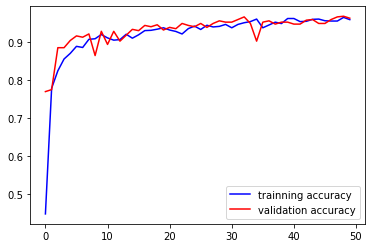

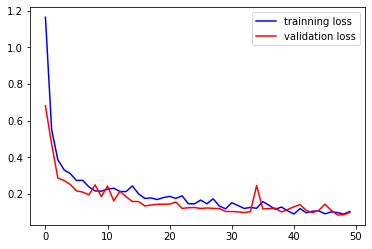

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [24]:
model.save("drowiness_new7.h5")

In [25]:
model.save("drowiness_new7.model")

INFO:tensorflow:Assets written to: drowiness_new7.model\assets


In [1]:
pip install tflite

     -------------------------------------- 123.6/123.6 kB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('drowiness_new7.h5')


In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpd_czr81d\assets


INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpd_czr81d\assets


In [4]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [5]:
import tensorflow as tf
import os 

In [6]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [7]:
from keras.models import load_model
model = load_model("drowiness_new7.h5")

TF_LITE_MODEL_FILE_NAME = "tflite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# or using another method

# Save the model.
with open('tflite_model_another.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpkif1cqyn\assets


INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpkif1cqyn\assets


File size: 1938.66 Kilobytes


INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpdlg5zm5i\assets


INFO:tensorflow:Assets written to: C:\Users\HRITHIK\AppData\Local\Temp\tmpdlg5zm5i\assets
